# Trader centrality calculation

Two seperate directed graphs for traders are built for each unique date found in the dataset.

In [1]:
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm

Original data

In [3]:
nft_transactions = pd.read_csv('data/Data_API.csv',usecols=['Seller_address','Buyer_address','Datetime_updated','Datetime_updated_seconds','Unique_id_collection','Collection_cleaned','Category'])

In [4]:
nft_transactions.Datetime_updated = pd.to_datetime(nft_transactions.Datetime_updated)
nft_transactions.Datetime_updated_seconds = pd.to_datetime(nft_transactions.Datetime_updated_seconds)

In [5]:
unique_dates = list(nft_transactions.groupby('Datetime_updated').groups.keys())

## Create networks and calculate centrality

In [6]:
G_seller = nx.DiGraph()
G_buyer = nx.DiGraph()
dataframes = []
for i, date in tqdm(enumerate(unique_dates), total=len(unique_dates)):
    # filter transactions to only include transactions between current and previous date
    prev_date = unique_dates[i-1] if i > 0 else unique_dates[0]
    date_mask = (nft_transactions.Datetime_updated >= prev_date) & (nft_transactions.Datetime_updated < date)
    date_transactions = nft_transactions.loc[date_mask]
  
    # add transactions as edges to the networks
    for index, row in date_transactions.iterrows():
        # add prefix '_' to nft ids to filter them later on (none of the addresses start with '_')
        G_seller.add_edges_from([(row.Seller_address, f'_{row.Unique_id_collection}')])
        G_buyer.add_edges_from([(row.Buyer_address, f'_{row.Unique_id_collection}')])
  
    # calculate centrality of nodes so far
    centrality_seller = nx.degree_centrality(G_seller)
    centrality_buyer = nx.degree_centrality(G_buyer)
    # filter to address nodes
    centrality_seller_address_nodes = {key:value for key, value in centrality_seller.items() if '_' not in key}.items()
    centrality_buyer_address_nodes = {key:value for key, value in centrality_buyer.items() if '_' not in key}.items()
    # convert dict items to pandas dataframe
    centrality_seller_address = pd.DataFrame(centrality_seller_address_nodes, columns=['Seller_address','centrality_seller'])
    centrality_buyer_address = pd.DataFrame(centrality_buyer_address_nodes, columns=['Buyer_address','centrality_buyer'])
    # merge with this dates nft transaction data
    merged_with_seller_and_buyer = (nft_transactions.loc[nft_transactions.Datetime_updated == date]
        .merge(centrality_seller_address, on='Seller_address', how='left')
        .merge(centrality_buyer_address, on='Buyer_address', how='left'))
    dataframes.append(merged_with_seller_and_buyer)

nft_transactions_with_centrality = pd.concat(dataframes)
nft_transactions_with_centrality

  0%|          | 0/1252 [00:00<?, ?it/s]

,Seller_address,Buyer_address,Datetime_updated,Datetime_updated_seconds,Unique_id_collection,Collection_cleaned,Category,centrality_seller,centrality_buyer
0,0x98139e00121ce58f35221f6e78aacf67dbefd822,0x30306c44c10cdaff1056f91695ee05b43756ae4f,2017-11-23,2017-11-23 23:58:59,"('Cryptokitties', '3354')",Cryptokittie,Art,NaN,NaN
1,0x51c3016d6699480ec6becdf2155079c27ebae040,0x78cff6a05343b7ab7d5dd453d39fa90427889e4e,2017-11-23,2017-11-23 23:55:55,"('Cryptokitties', '3348')",Cryptokittie,Art,NaN,NaN
2,0x6e129c4bef43eb234a10b969f15bc564511bec6c,0x173216d1fd08e76fd4f25710d2849091ce2fb026,2017-11-23,2017-11-23 23:54:37,"('Cryptokitties', '3321')",Cryptokittie,Art,NaN,NaN
3,0x1fd9277f03bd18f740bffbf9f160f10bd8fa9f11,0xadbee7390043da115bdacb68cc218a507c4210fa,2017-11-23,2017-11-23 23:51:14,"('Cryptokitties', '1404')",Cryptokittie,Art,NaN,NaN
4,0x6e129c4bef43eb234a10b969f15bc564511bec6c,0x1a40ca0774518d8f7f41df7da070a4aae08184f1,2017-11-23,2017-11-23 23:48:24,"('Cryptokitties', '3319')",Cryptokittie,Art,NaN,NaN
...,...,...,...,...,...,...,...,...,...
154440,0x6acad2cb890c7f095ca3c4840a135df4517b3067,0x34e7d90199f6c40f19e20cacd53687f4031b293d,2021-04-27,2021-04-27 00:05:26,"('Glewme-city-real-estate', '49006244057585521...",Glewmecityrealestate,Metaverse,0.000011,9.174802e-06
154441,0x400cbcf4b2a30aac711fc5a882fcaf485cce6f04,0x8f9e6dd01128cc3c148902ebfa648bfcb68ad1ce,2021-04-27,2021-04-27 00:01:19,"('Rarible', '297669')",Rari,Art,0.000006,NaN
154442,0xd65b30057bf6f8ee3571f27e286fbbd6107868b8,0xd98695e2fce07e908c9f523387b1b1f8eb9d41ec,2021-04-27,2021-04-27 00:01:20,"('Hashmasks', '11312')",Hashmask,Art,0.000004,6.116535e-07
154443,0x252d95edd1fa68bcdca548df93a2738294357188,0x685731e1e7ebd3a068b0ea697c4fb93ecb40e8dc,2021-04-27,2021-04-27 00:00:57,"('Art-blocks', '53000219')",Art,Art,0.000002,2.038845e-07


<Axes: >

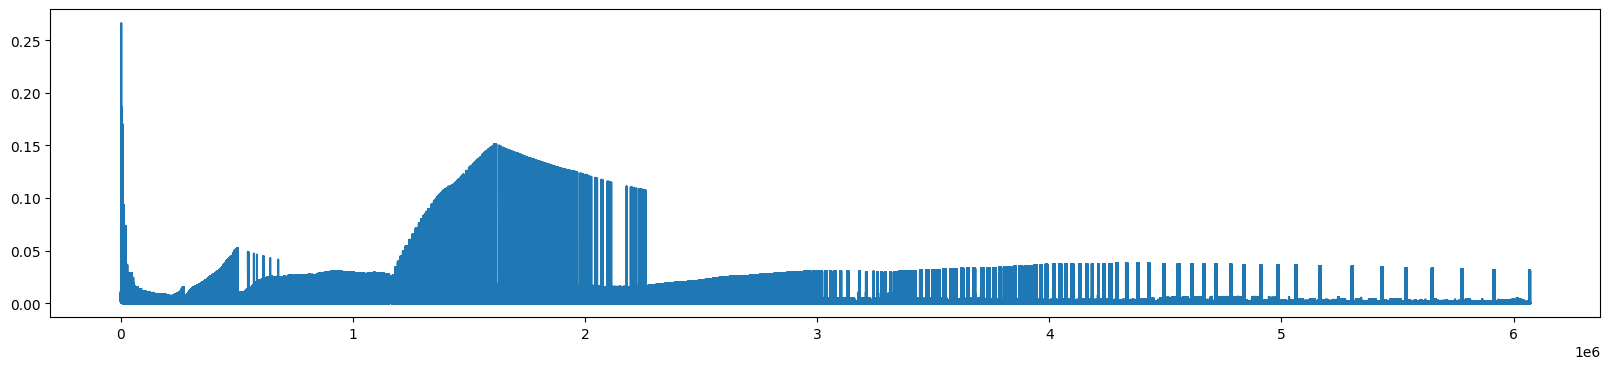

In [7]:
nft_transactions_with_centrality.reset_index().centrality_seller.plot(figsize=(20,4))

<Axes: >

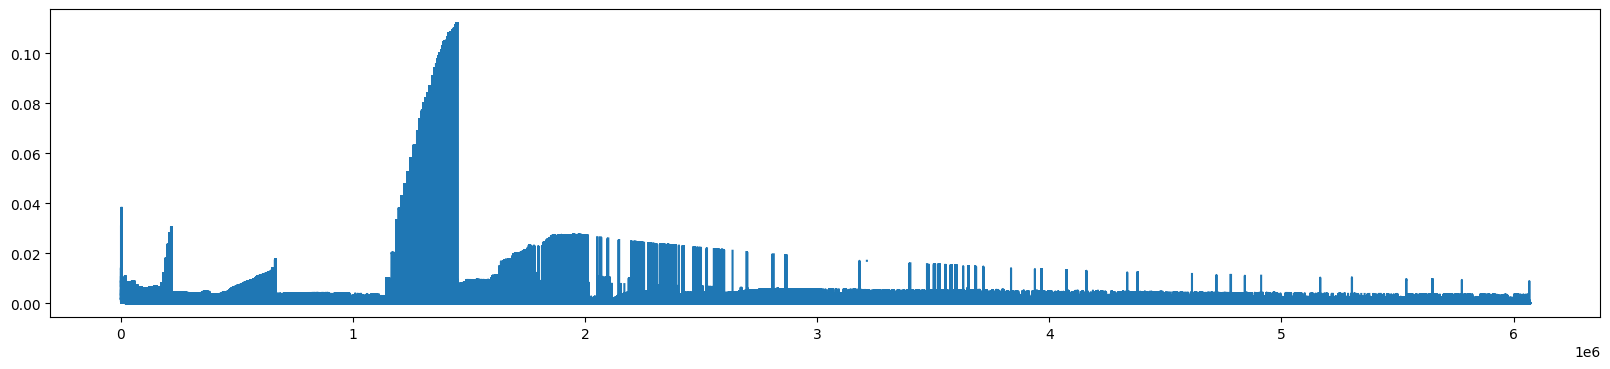

In [8]:
nft_transactions_with_centrality.reset_index().centrality_buyer.plot(figsize=(20,4))